#🎯 Project: Meme Search

##⚙️ Initial Setup

In [ ]:
# @title 🔧 Install Dependencies
!pip -q install transformers==4.41.0
!pip -q install pillow tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 37.5 MB/s eta 0:00:00


In [ ]:
# @title 📦 Import Libraries
import torch
import torch.nn.functional as F
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from pathlib import Path
import urllib.request
from tqdm.auto import tqdm

In [ ]:
# @title ⚙️ Define Configuration
# Set constants
DATA_DIR   = Path("/content/memes")
MODEL_NAME = "openai/clip-vit-base-patch32"
TOP_K      = 5

# Meme image URLs
MEME_URLS = {
    "meme_1.png": "https://ml-hiring.fringecore.sh/meme_search/meme_1.png",
    "meme_2.webp": "https://ml-hiring.fringecore.sh/meme_search/meme_2.webp",
    "meme_3.jpg": "https://ml-hiring.fringecore.sh/meme_search/meme_3.jpg",
    "meme_4.jpg": "https://ml-hiring.fringecore.sh/meme_search/meme_4.jpg",
    "meme_5.jpg": "https://ml-hiring.fringecore.sh/meme_search/meme_5.jpg"
}

# Create folder if not exists
DATA_DIR.mkdir(exist_ok=True)

##💻 Codes

In [ ]:
# @title 📥 Download Meme Images
def download_memes(url_dict, dest_dir):
    headers = {'User-Agent': 'Mozilla/5.0'}
    for fname, url in tqdm(url_dict.items(), desc="Downloading memes"):
        fpath = dest_dir / fname
        if not fpath.exists():
            req = urllib.request.Request(url, headers=headers)
            with urllib.request.urlopen(req) as response, open(fpath, 'wb') as out_file:
                out_file.write(response.read())
    return sorted(dest_dir.glob("*"))

meme_paths = download_memes(MEME_URLS, DATA_DIR)
print(f"✅ Downloaded {len(meme_paths)} memes.")

✅ Downloaded 5 memes.


In [ ]:
# @title 🧠 Load CLIP Model
# Load model and processor
device        = "cuda" if torch.cuda.is_available() else "cpu"
clip_model    = CLIPModel.from_pretrained(MODEL_NAME).to(device).eval()
processor     = CLIPProcessor.from_pretrained(MODEL_NAME)

print(f"✅ CLIP model loaded on {device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

✅ CLIP model loaded on cpu


In [ ]:
# @title 🖼️ Embed Meme Images
def embed_images(paths):
    """Embeds image files using CLIP and returns a dict of embeddings."""
    embeddings = {}
    for path in tqdm(paths, desc="Embedding memes"):
        image = Image.open(path).convert("RGB")
        inputs = processor(images=image, return_tensors="pt").to(device)

        with torch.no_grad():
            img_emb = clip_model.get_image_features(**inputs)
            img_emb = img_emb / img_emb.norm(dim=-1, keepdim=True)
            embeddings[path.name] = img_emb.squeeze(0).cpu()

    return embeddings

image_embeddings = embed_images(meme_paths)
print(f"✅ Embedded {len(image_embeddings)} memes.")

Embedding memes:   0%|          | 0/5 [00:00<?, ?it/s]

✅ Embedded 5 memes.


In [ ]:
# @title 🔎 Define Search Function
def search_memes(query, top_k=TOP_K):
    """Search for memes that are most similar to the text query."""
    # Text embedding
    inputs = processor(text=[query], return_tensors="pt").to(device)
    with torch.no_grad():
        text_emb = clip_model.get_text_features(**inputs)
        text_emb = text_emb / text_emb.norm(dim=-1, keepdim=True)

    # Cosine similarity with all images
    results = []
    for name, img_emb in image_embeddings.items():
        sim = F.cosine_similarity(text_emb.cpu(), img_emb.unsqueeze(0), dim=1)
        results.append((name, sim.item()))

    # Return top_k sorted
    return sorted(results, key=lambda x: x[1], reverse=True)[:top_k]

##🔎 Eval

Top match for: 'girl crying'
1. meme_5.jpg (score: 0.2443)


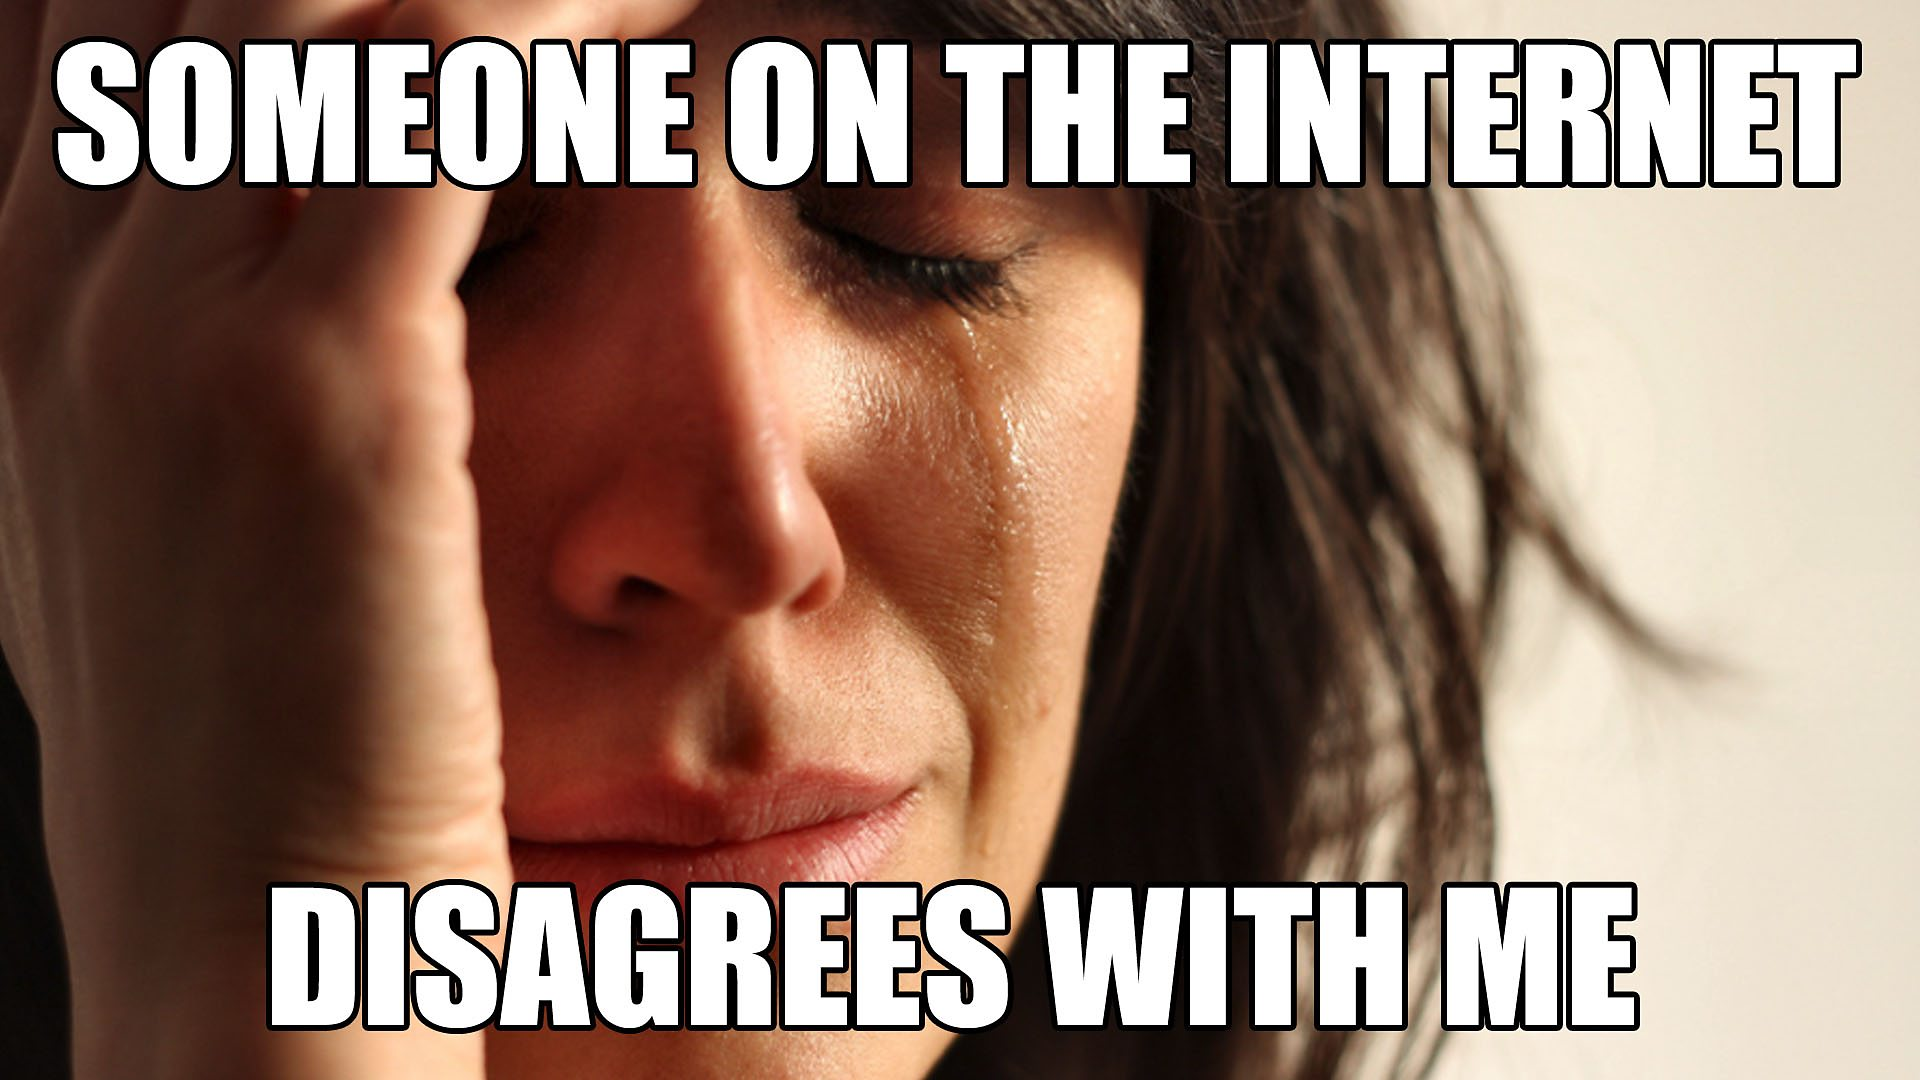

In [ ]:
# @title 🔍 Search Memes
query = "girl crying"  # @param {type:"string", placeholder:"e.g. girl crying"}

# Run the search for top 1
results = search_memes(query, top_k=1)

print(f"Top match for: '{query}'")
for i, (name, score) in enumerate(results, 1):
    print(f"{i}. {name} (score: {score:.4f})")

# Display the top meme image
from IPython.display import display
def show_memes(filenames):
    for fname in filenames:
        display(Image.open(DATA_DIR / fname))

show_memes([name for name, _ in results])